# ABIDE Subtype analysis
The goal of this notebook is to run a subtype analysis on the ABIDE dataset and to look at the subtype weights following Pierre Orban's analysis. Here are the central research questions:

1. What are subtypes of scores maps for different networks (7 network resolution on Cambridge) and how do they look like?
2. What are the individual subject weights for these subtypes (violin plots and Pierre's matrix)
3. For which networks and subtypes is diagnosis a significant predictor of weights?
4. What do weights for these subtypes and networks look like for patients and healthy controls?
5. For which networks and subtypes are dimensional scores like IQ significant predictors of weights?
5. What does the scatterplot of weights over IQ look like?

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import nilearn as nil
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as slin
from statsmodels.sandbox import stats as sts
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.sandbox.stats import multicomp as smi

In [2]:
%matplotlib inline

# Paths

In [3]:
# Paths
scale = 12
name = 'n308_sample'
mtp = 'stability_maps'
prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale{:03d}.nii.gz'.format(scale)
pheno_path = '/data1/abide/Pheno/unconstrained_2box_308_sample.csv'
netstack_path = '/data1/subtypes/serial_preps/netstack_demeaned_{}_scale_{:03d}.npy'.format(name, scale)
netraw_path = '/data1/subtypes/serial_preps/netstack_raw_{}_scale_{:03d}.npy'.format(name, scale)
corrmat_path = '/data1/subtypes/serial_preps/correlation_matrix_{}_scale_{:03d}.npy'.format(name, scale)
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
out_path = '/data1/subtypes/sc12'

In [4]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [5]:
# Get the phenotype data
pheno = pd.read_csv(pheno_path)

In [6]:
# add coded variable for ratio of VIQ and PIQ
pheno['VerbRatio'] = pheno['VIQ'] / pheno['PIQ']

In [7]:
# Get the prior
p_img = nib.load(prior_path)
prior = p_img.get_data()

In [8]:
# Turn the priors into an image
prior = nib.load(prior_path)
prior_data = prior.get_data()
prior_temp = np.zeros((prior_data.shape + (scale,)))
for sc_id in range(scale):
    tmp = np.zeros_like(prior_data)
    tmp[prior_data==sc_id+1] = sc_id + 1
    prior_temp[..., sc_id] = tmp
prior_img = nib.Nifti1Image(prior_temp, affine=m_img.get_affine(), header=m_img.get_header())

# Define some functions and the niak colormap

In [9]:
# Define a new colormap
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (0.25, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.25, 1.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
hotcold = LinearSegmentedColormap('hotcold', cdict)

## Build the subtypes and compute the weights

In [10]:
# Load the serialized netstack
netstack = np.load(netstack_path)

corr_mat = np.load(corrmat_path)

In [11]:
# Make the grand average
gdavg = np.zeros(mask.shape + (scale,))

In [12]:
netraw = np.load(netraw_path)

In [13]:
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
inv_list = ['VIQ',  'ADOS_TOTAL', 'DX_GROUP']
subtypes = 5

scale = netstack.shape[0]
n_sub = netstack.shape[2]
n_vox = netstack.shape[1]

link_store = np.zeros((n_sub-1,4,scale))
part_store = np.zeros((scale, n_sub))
sbt_store = np.zeros((scale, subtypes, n_vox))
weight_store = np.zeros((scale, subtypes, n_sub))

# Iterate through the networks
for net_id in range(scale):
    # Compute linkage with Ward's criterion
    link_mat = scl.hierarchy.linkage(corr_mat[net_id, ...] , method='ward')
    link_store[..., net_id] = link_mat
    # Partition the linkage to get a given number of subtypes
    part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
    part_store[net_id, :] = part_sub

    sub_stack = np.zeros((n_vox, subtypes))
    for s_id in range(subtypes):
        sbt = np.mean(netstack[net_id, :, part_sub==s_id+1],0)
        sub_stack[:,s_id] = sbt
        sbt_store[net_id, s_id, :] = sbt

    # Init store - Compute the weights
    for s_id in range(subtypes):
        type_map = sub_stack[:, s_id]
        weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])

    # Init store - Compute the weights
    for s_id in range(subtypes):
        type_map = sub_stack[:, s_id]
        weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])

In [14]:
# Reduce the phenotype data to those subjects 
# that actually have the covariate of interest
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
cov = cov_list[-3]
cov_index = pd.notnull(pheno.replace(-9999, np.nan)[cov])

In [15]:
print('{} has {}'.format(cov, np.sum(cov_index)))

ADOS_TOTAL has 136


In [16]:
cov_pheno = pheno[cov_index]
# Generate the model matrix
factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = cov_pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
#other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Demean the covariate
other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

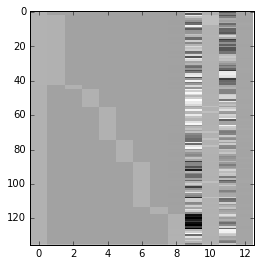

In [17]:
fig = plt.figure(figsize=(4,10))
ax = fig.add_subplot(111)
ax.imshow(glm_pheno, aspect=0.1, interpolation='None', cmap=plt.cm.Greys_r)

In [18]:
cov_weight = weight_store[..., cov_index.values]

In [19]:
res_store = list()
pval_store = np.zeros((scale, subtypes))
for net_id in range(scale):
    res_list = list()
    # Loop through the subtypes
    for s_id in range(subtypes):
        model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
        results = model.fit()
        # Save the p-values
        pval_store[net_id, s_id] = results.pvalues[cov]
        res_list.append(results)
    res_store.append(res_list)

# Look at the results

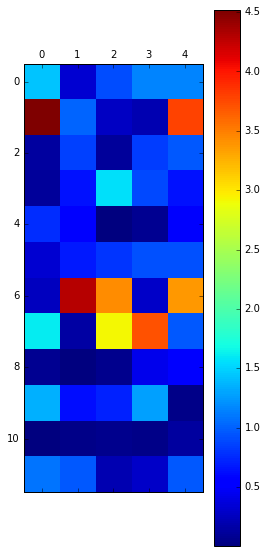

In [20]:
# Look at the uncorrected p-values for the GLM with diagnosis across networks
tmp = plt.matshow(-np.log10(pval_store))
tmp = plt.colorbar()

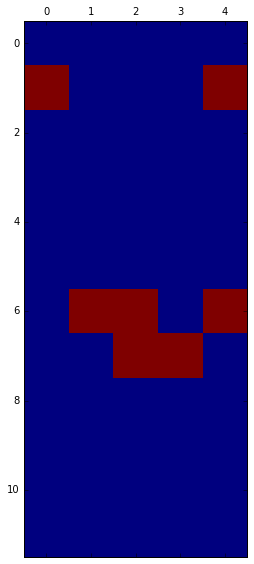

In [21]:
# Now look at the mask of p-values passing FDR Correction
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)
tmp = plt.matshow(pcorr_store)

In [22]:
gdavg_img = nib.Nifti1Image(gdavg, affine=m_img.get_affine(), header=m_img.get_header())

In [23]:
def show_simple(net_id, sbt_id, gdavg_img, sbt_store, view_mode='x', threshold=0.1, 
                view_range=[-70,-50, -30, -10, 10, 30, 50, 70]):

    sbt = sbt_store[net_id, sbt_id,:]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt
    sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    fig = plt.figure(figsize=(15,3))
    ax = fig.add_subplot(111)
    nlp.plot_stat_map(sbt_img, display_mode='x', threshold=threshold, 
                      cut_coords=view_range, black_bg=True,
                     axes=ax)
    return fig

In [24]:
view_range=[-70,-50, -30, -10, 10, 30, 50, 70]

## ADOS

### Network 1

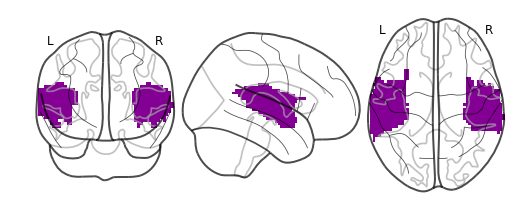

In [25]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 1), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

### pos

In [26]:
print(res_store[1][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     10.02
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           1.81e-13
Time:                        02:29:12   Log-Likelihood:                 77.087
No. Observations:                 136   AIC:                            -128.2
Df Residuals:                     123   BIC:                            -90.31
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.1882      0.121     -1.550      

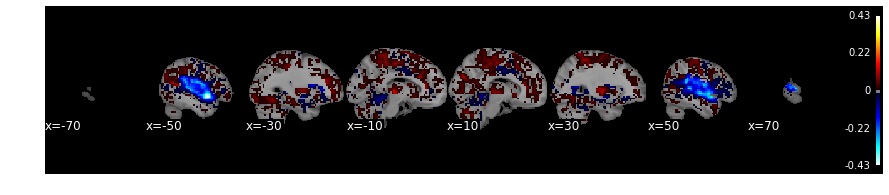

In [27]:
tmp = show_simple(1,0,gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

### neg

In [28]:
print(res_store[1][4].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     7.887
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           9.21e-11
Time:                        02:29:13   Log-Likelihood:                 85.253
No. Observations:                 136   AIC:                            -144.5
Df Residuals:                     123   BIC:                            -106.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.1129      0.114      0.987      

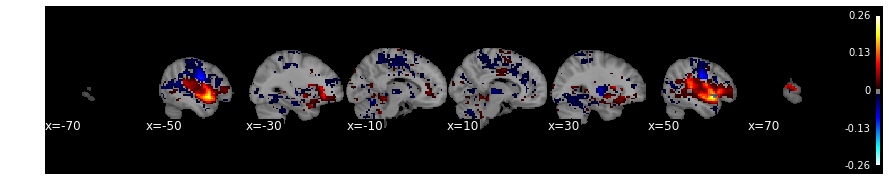

In [29]:
tmp = show_simple(1,4,gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

## Network 6

In [ ]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 6), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

### neg

In [31]:
print(res_store[6][1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     5.262
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           4.22e-07
Time:                        02:29:14   Log-Likelihood:                 34.621
No. Observations:                 136   AIC:                            -43.24
Df Residuals:                     123   BIC:                            -5.377
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.0652      0.166      0.393      

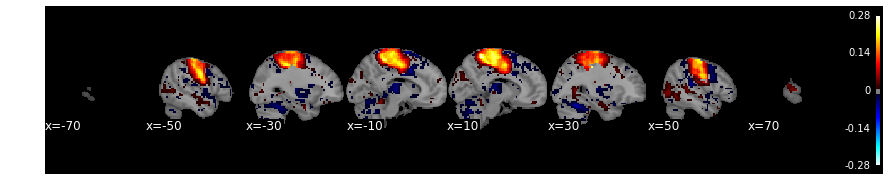

In [32]:
tmp = show_simple(6,1,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

### pos

In [33]:
print(res_store[6][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     5.525
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           1.74e-07
Time:                        02:29:15   Log-Likelihood:                 31.984
No. Observations:                 136   AIC:                            -37.97
Df Residuals:                     123   BIC:                           -0.1041
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.0475      0.169     -0.281      

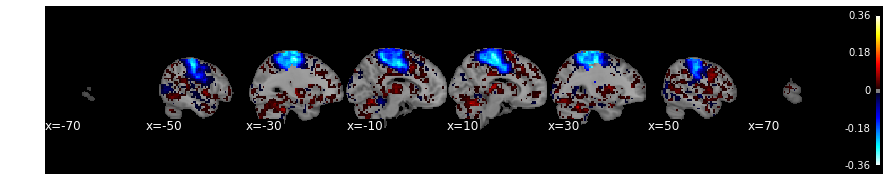

In [34]:
tmp = show_simple(6,2,gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [35]:
print(res_store[6][4].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     4.448
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           6.75e-06
Time:                        02:29:16   Log-Likelihood:                 49.918
No. Observations:                 136   AIC:                            -73.84
Df Residuals:                     123   BIC:                            -35.97
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.0230      0.148     -0.155      

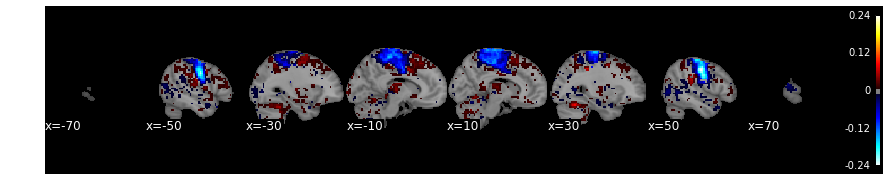

In [36]:
tmp = show_simple(6,4, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

### Network 7

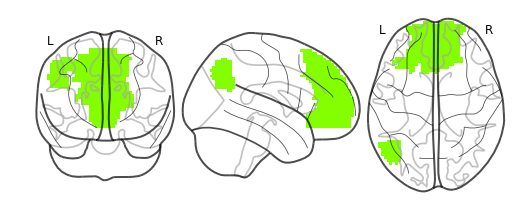

In [37]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 7), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

### neg

In [38]:
print(res_store[7][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     4.478
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           6.10e-06
Time:                        02:29:18   Log-Likelihood:                 78.872
No. Observations:                 136   AIC:                            -131.7
Df Residuals:                     123   BIC:                            -93.88
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.1762      0.120      1.470      

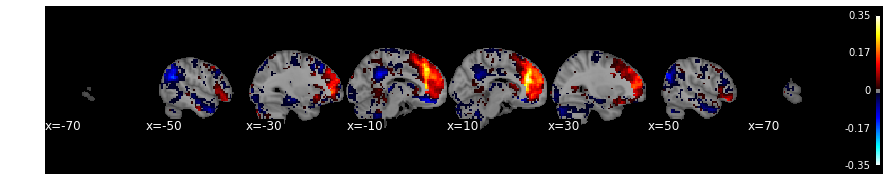

In [39]:
tmp = show_simple(7,2, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

### pos

In [40]:
print(res_store[7][3].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     2.755
Date:                Sun, 08 Nov 2015   Prob (F-statistic):            0.00240
Time:                        02:29:19   Log-Likelihood:                 71.736
No. Observations:                 136   AIC:                            -117.5
Df Residuals:                     123   BIC:                            -79.61
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.1411      0.126     -1.117      

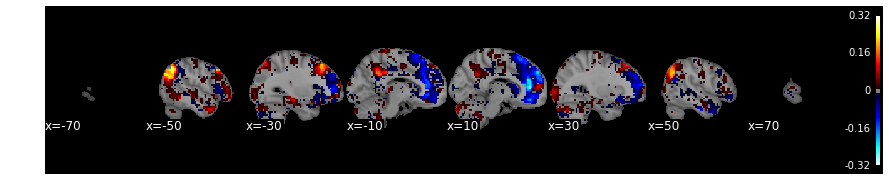

In [41]:
tmp = show_simple(7,3, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

# Look at diagnosis

DX_GROUP has 308


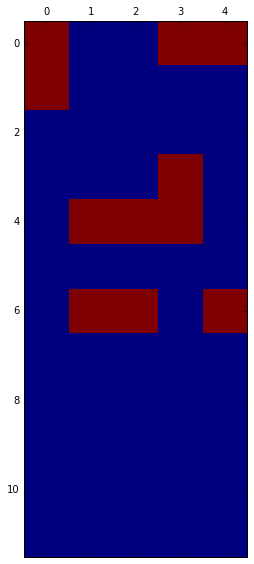

In [42]:
# Reduce the phenotype data to those subjects 
# that actually have the covariate of interest
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
cov = cov_list[-1]
cov_index = pd.notnull(pheno.replace(-9999, np.nan)[cov])

print('{} has {}'.format(cov, np.sum(cov_index)))

cov_pheno = pheno[cov_index]
# Generate the model matrix
factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = cov_pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
#other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Demean the covariate
other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

cov_weight = weight_store[..., cov_index.values]

res_store = list()
pval_store = np.zeros((scale, subtypes))
for net_id in range(scale):
    res_list = list()
    # Loop through the subtypes
    for s_id in range(subtypes):
        model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
        results = model.fit()
        # Save the p-values
        pval_store[net_id, s_id] = results.pvalues[cov]
        res_list.append(results)
    res_store.append(res_list)
    
# Now look at the mask of p-values passing FDR Correction
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)
tmp = plt.matshow(pcorr_store)

## Network 0

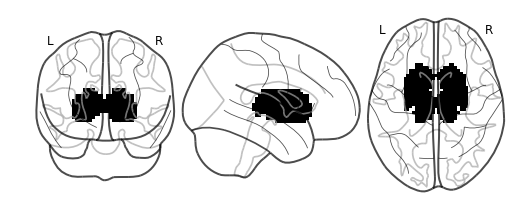

In [43]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 0), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

### neg (pos diag)

In [44]:
print(res_store[0][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     14.26
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           1.15e-24
Time:                        02:29:21   Log-Likelihood:                 127.92
No. Observations:                 308   AIC:                            -227.8
Df Residuals:                     294   BIC:                            -175.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.2919      0.064     -4.534      

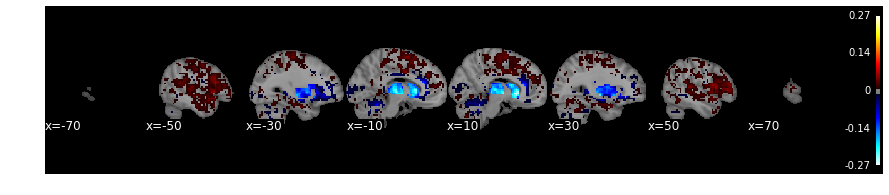

In [45]:
tmp = show_simple(0,0, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

### pos (neg diag)

In [46]:
print(res_store[0][3].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     7.537
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           7.73e-13
Time:                        02:29:22   Log-Likelihood:                 152.14
No. Observations:                 308   AIC:                            -276.3
Df Residuals:                     294   BIC:                            -224.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.1593      0.060      2.677      

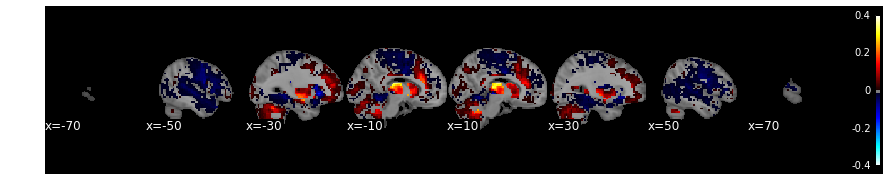

In [47]:
tmp = show_simple(0,3, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [48]:
print(res_store[0][4].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     31.00
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           1.27e-47
Time:                        02:29:23   Log-Likelihood:                 215.30
No. Observations:                 308   AIC:                            -402.6
Df Residuals:                     294   BIC:                            -350.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.2751      0.048      5.675      

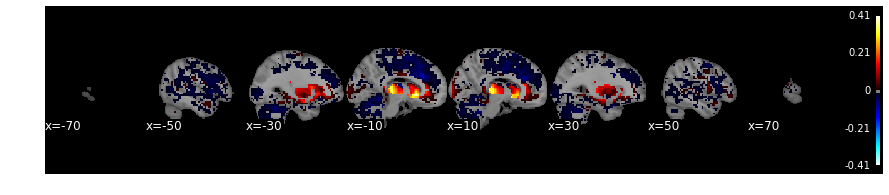

In [49]:
tmp = show_simple(0,4, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

## Network 4

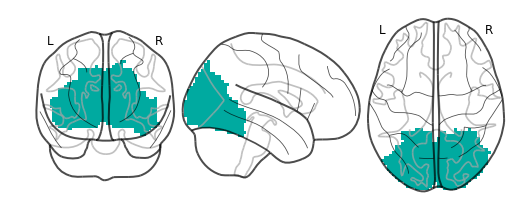

In [50]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 4), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

### pos (neg diag)

In [51]:
print(res_store[4][1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     6.620
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           4.29e-11
Time:                        02:29:25   Log-Likelihood:                 89.509
No. Observations:                 308   AIC:                            -151.0
Df Residuals:                     294   BIC:                            -98.80
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.2484      0.073      3.406      

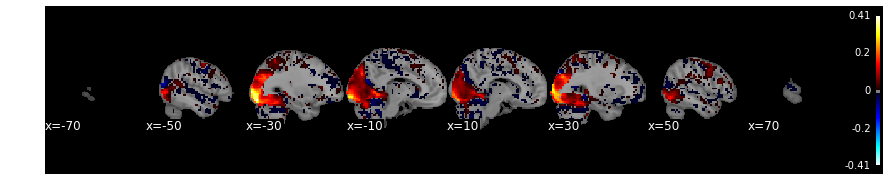

In [52]:
tmp = show_simple(4,1, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [53]:
print(res_store[4][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     9.472
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           2.02e-16
Time:                        02:29:25   Log-Likelihood:                 116.75
No. Observations:                 308   AIC:                            -205.5
Df Residuals:                     294   BIC:                            -153.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.1702      0.067      2.550      

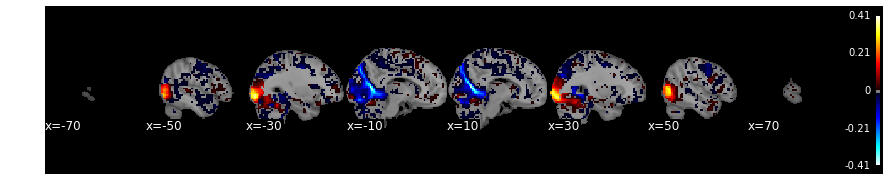

In [54]:
tmp = show_simple(4,2, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

### neg (pos diag)

In [55]:
print(res_store[4][3].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     9.623
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           1.07e-16
Time:                        02:29:27   Log-Likelihood:                 118.98
No. Observations:                 308   AIC:                            -210.0
Df Residuals:                     294   BIC:                            -157.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.1836      0.066     -2.771      

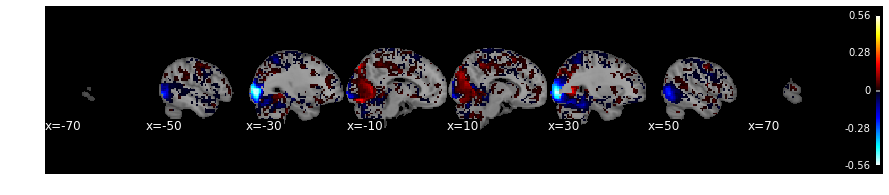

In [56]:
tmp = show_simple(4,3, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

## Network 6

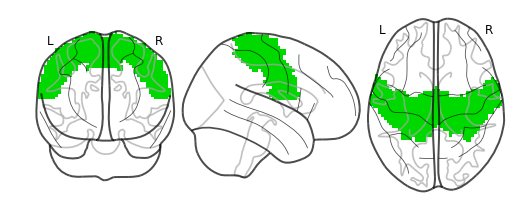

In [57]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 6), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

### pos (neg diag)

In [58]:
print(res_store[6][1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     10.25
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           7.98e-18
Time:                        02:29:28   Log-Likelihood:                 49.710
No. Observations:                 308   AIC:                            -71.42
Df Residuals:                     294   BIC:                            -19.20
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.4625      0.083      5.573      

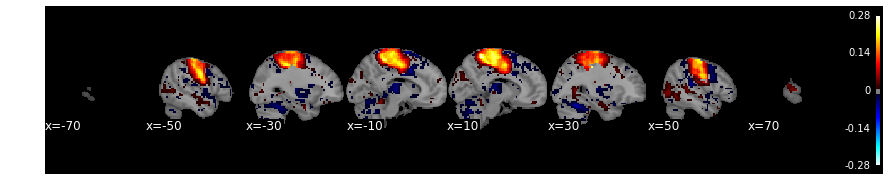

In [59]:
tmp = show_simple(6,1, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

### neg (pos diag)

In [60]:
print(res_store[6][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     9.522
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           1.63e-16
Time:                        02:29:29   Log-Likelihood:                 51.013
No. Observations:                 308   AIC:                            -74.03
Df Residuals:                     294   BIC:                            -21.81
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.4750      0.083     -5.749      

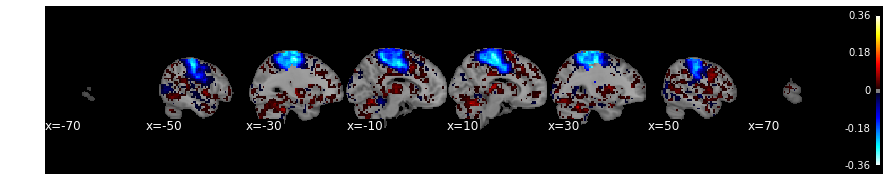

In [61]:
tmp = show_simple(6,2, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [62]:
print(res_store[6][4].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     10.80
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           8.59e-19
Time:                        02:29:30   Log-Likelihood:                 98.244
No. Observations:                 308   AIC:                            -168.5
Df Residuals:                     294   BIC:                            -116.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.3468      0.071     -4.893      

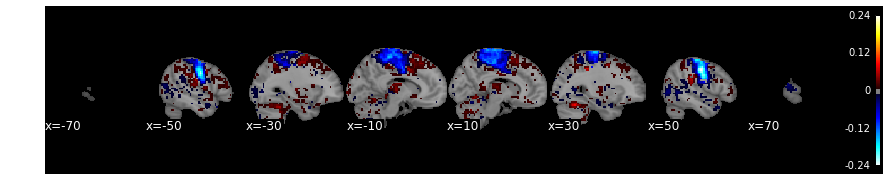

In [63]:
tmp = show_simple(6,4, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

# VIQ

VIQ has 276


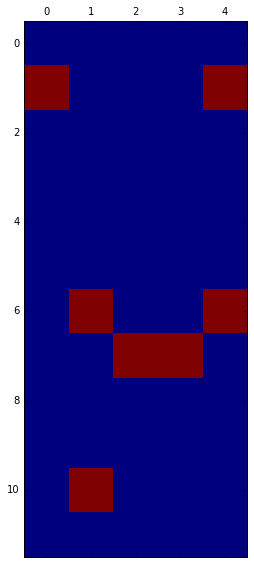

In [64]:
# Reduce the phenotype data to those subjects 
# that actually have the covariate of interest
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
cov = cov_list[1]
cov_index = pd.notnull(pheno.replace(-9999, np.nan)[cov])

print('{} has {}'.format(cov, np.sum(cov_index)))

cov_pheno = pheno[cov_index]
# Generate the model matrix
factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = cov_pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
#other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Demean the covariate
other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

cov_weight = weight_store[..., cov_index.values]

res_store = list()
pval_store = np.zeros((scale, subtypes))
for net_id in range(scale):
    res_list = list()
    # Loop through the subtypes
    for s_id in range(subtypes):
        model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
        results = model.fit()
        # Save the p-values
        pval_store[net_id, s_id] = results.pvalues[cov]
        res_list.append(results)
    res_store.append(res_list)
    
# Now look at the mask of p-values passing FDR Correction
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)
tmp = plt.matshow(pcorr_store)

## Network 1

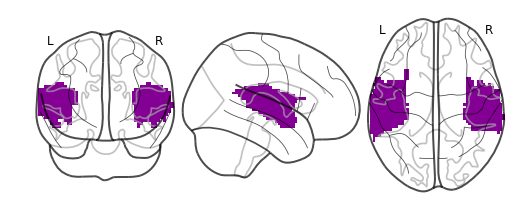

In [65]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 1), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [66]:
print(res_store[1][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     17.01
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           9.88e-24
Time:                        02:29:32   Log-Likelihood:                 151.49
No. Observations:                 276   AIC:                            -281.0
Df Residuals:                     265   BIC:                            -241.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.4810      0.058     -8.310      

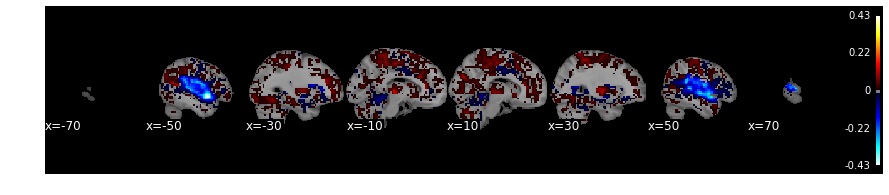

In [67]:
tmp = show_simple(1,0, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [80]:
print(res_store[1][4].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     20.06
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           1.83e-27
Time:                        02:30:46   Log-Likelihood:                 161.61
No. Observations:                 276   AIC:                            -301.2
Df Residuals:                     265   BIC:                            -261.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.3653      0.056      6.548      

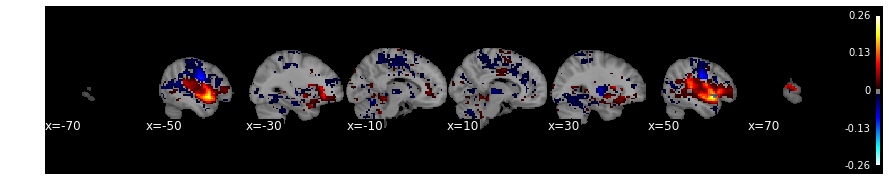

In [81]:
tmp = show_simple(1,4, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

## Network 6

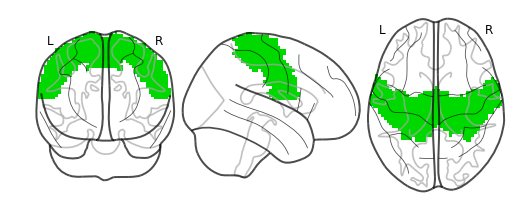

In [70]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 6), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [71]:
print(res_store[6][1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     7.739
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           7.24e-11
Time:                        02:29:35   Log-Likelihood:                 33.247
No. Observations:                 276   AIC:                            -44.49
Df Residuals:                     265   BIC:                            -4.670
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.4502      0.089      5.068      

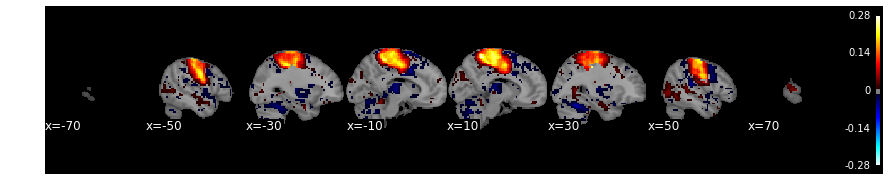

In [72]:
tmp = show_simple(6,1, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [73]:
print(res_store[6][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     7.005
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           9.46e-10
Time:                        02:29:37   Log-Likelihood:                 35.611
No. Observations:                 276   AIC:                            -49.22
Df Residuals:                     265   BIC:                            -9.399
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.4552      0.088     -5.169      

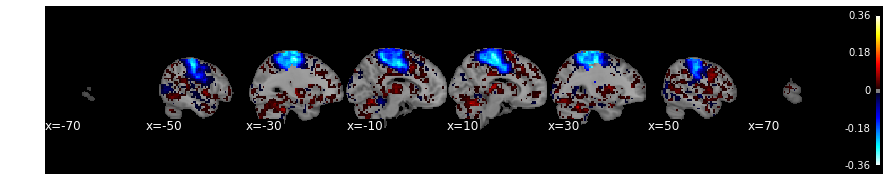

In [74]:
tmp = show_simple(6,2, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

## Network 7

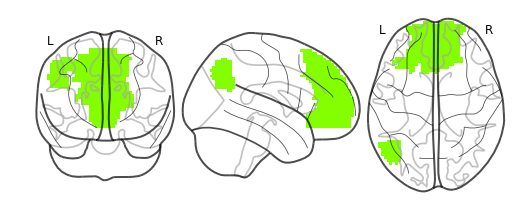

In [75]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 7), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [76]:
print(res_store[7][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     11.27
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           4.84e-16
Time:                        02:29:38   Log-Likelihood:                 150.78
No. Observations:                 276   AIC:                            -279.6
Df Residuals:                     265   BIC:                            -239.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.2655      0.058      4.576      

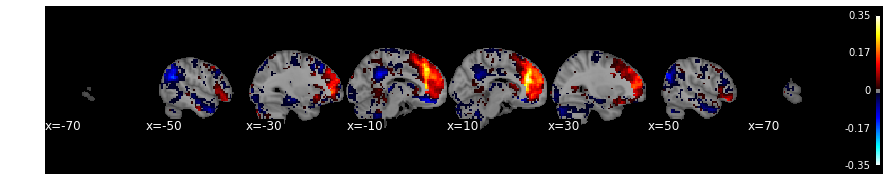

In [77]:
tmp = show_simple(7,2, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [78]:
print(res_store[7][3].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     5.195
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           5.85e-07
Time:                        02:29:39   Log-Likelihood:                 145.43
No. Observations:                 276   AIC:                            -268.9
Df Residuals:                     265   BIC:                            -229.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.1867      0.059     -3.156      

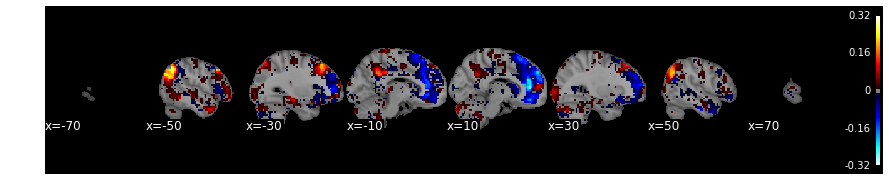

In [79]:
tmp = show_simple(7,3, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)